# Analysis 2

Second program to predict the GDP growth.

We solved the previous program problem and now the model predicts the GDP growth of the next year.

This code does not run with the actual settings. It's just for documenting the process.

In [1]:
import sys
sys.path.append("..")

import utils
from utils import config

import time
import sqlite3
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

import time

In [2]:
%%time
#Load data from the dataset
indicators = config.INDICATORS
target = config.TARGET
separator = "','"
sql_string = f""" SELECT
                t2.Country,
                t1.Year,
                t3.IndicatorName,
                t1.Value                
                FROM CountryIndicators t1
                LEFT JOIN
                (SELECT ShortName as Country, CountryCode from Countries) t2
                ON t1.CountryCode = t2.CountryCode
                LEFT JOIN
                (SELECT IndicatorCode, IndicatorName from Indicators)t3
                ON t1.IndicatorCode = t3.IndicatorCode
                WHERE t3.IndicatorName in ('{separator.join(indicators)}');"""

with sqlite3.connect(config.DATABASE_PATH) as conn:
    country_indicators_df = pd.read_sql(sql_string,conn)

CPU times: user 4.4 s, sys: 106 ms, total: 4.5 s
Wall time: 4.51 s


In [3]:
pivoted_df = country_indicators_df.pivot(values='Value', index=['Country', 'Year'], columns=['IndicatorName'])
target_df = country_indicators_df.loc[country_indicators_df["IndicatorName"] == target].copy()
target_df["Year"] -= 1
target_df.set_index(["Country", "Year"], inplace=True)
target_df.rename(columns={"Value": "Next GDP Growth"}, inplace=True)
target_df.drop(columns=["IndicatorName"], inplace=True)
df = pivoted_df.join(target_df)

#We left Country and year as index
df = df.dropna(axis='columns',thresh=6000)
df = df.dropna()
df

Agriculture, value added (% of GDP)  \
Country     Year                                        
Afghanistan 2003                            37.765444   
            2004                            30.271674   
            2005                            31.750991   
            2006                            29.249737   
            2007                            30.622854   
...                                               ...   
Zimbabwe    2005                            18.577279   
            2006                            20.281820   
            2007                            21.597907   
            2008                            19.398886   
            2009                            15.071770   

                  CO2 emissions (kg per 2005 US$ of GDP)  \
Country     Year                                           
Afghanistan 2003                                0.185800   
            2004                                0.169567   
            2005                                0.213297   
            2006                                0.250239   
            2007                                0.302756   
...                                                  ...   
Zimbabwe    2005                                1.861785   
            2006                                1.844721   
            2007                                1.818080   
            2008                                1.743141   
            2009                                1.764045   

                  Coal rents (% of GDP)  \
Country     Year                          
Afghanistan 2003               0.004666   
            2004               0.018587   
            2005               0.010937   
            2006               0.011345   
            2007               0.083463   
...                                 ...   
Zimbabwe    2005               0.905147   
            2006               1.059730   
            2007               1.790678   
            2008               4.968032   
            2009               0.959147   

                  Discrepancy in expenditure estimate of GDP (current LCU)  \
Country     Year                                                             
Afghanistan 2003                                       0.000000e+00          
            2004                                       0.000000e+00          
            2005                                       1.000000e+02          
            2006                                      -1.950000e+05          
            2007                                      -5.033000e+05          
...                                                             ...          
Zimbabwe    2005                                      -1.000000e+02          
            2006                                       2.750000e-07          
            2007                                       1.000000e+02          
            2008                                       1.670000e-06          
            2009                                       7.519306e+00          

                  Exports of goods and services (% of GDP)  \
Country     Year                                             
Afghanistan 2003                                 43.556869   
            2004                                 33.996494   
            2005                                 27.395256   
            2006                                 26.470293   
            2007                                 17.823714   
...                                                    ...   
Zimbabwe    2005                                 33.548648   
            2006                                 35.956169   
            2007                                 37.785373   
            2008                                 41.466849   
            2009                                 22.013601   

                  External balance on goods and services (% of GDP)  \
Country     Year                          

In [4]:
#Features List
features = df.columns.tolist()
features.remove('GDP growth (annual %)')
features.remove("Next GDP Growth")
print("Features Len:",len(features))

#Target
target = "Next GDP Growth"

y = df[target]
X = df[features]

Features Len: 38


In [5]:
#Gradient Boosting Model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


gbm_hyperparams = {
    'n_estimators': 100,
    'max_depth': 10,
    'learning_rate': 0.1,
    'loss': 'ls'
}
gbm_model = GradientBoostingRegressor(**gbm_hyperparams)

t0 = time.time()
gbm_model.fit(X_train, y_train)
print(f"Elapsed time training: {time.time() - t0} seconds")
t0 = time.time()
gbm_y_pred = gbm_model.predict(X_test)
print(f"Elapsed time predicting: {time.time() - t0} seconds")

results_df = X_test
results_df = results_df.drop(columns=features)
results_df["y_real"] = y_test
results_df["y_pred"] = gbm_y_pred
results_df["err"] = np.absolute(results_df["y_real"] - results_df["y_pred"])
results_df["%_err"] = ((results_df["err"]) /(np.absolute (results_df["y_real"]))* 100)

print(f"RMSE: {mean_squared_error(y_test, gbm_y_pred)**0.5}")
print(f"R^2: {r2_score(y_test, gbm_y_pred)}")

results_df 

X_train shape: (2494, 38)
X_test shape: (1070, 38)
y_train shape: (2494,)
y_test shape: (1070,)
Elapsed time training: 6.161245822906494 seconds
Elapsed time predicting: 0.006696224212646484 seconds
RMSE: 4.601059305929046
R^2: 0.11115601642077544


,,y_real,y_pred,err,%_err
Country,Year,,,,
Nepal,1990,6.368150,5.718876,0.649274,10.195644
Belize,2008,0.713251,2.968195,2.254944,316.150252
Nigeria,1989,12.766009,5.167267,7.598742,59.523239
Brazil,1983,5.269143,1.429826,3.839317,72.864164
Congo,1984,-1.185661,6.927110,8.112771,684.240419
...,...,...,...,...,...
Netherlands,1977,2.696247,2.910910,0.214663,7.961565
Guinea,2002,1.248601,4.485509,3.236908,259.242748
Dominican Republic,1977,2.140685,5.186391,3.045707,142.277219


The predictions are not really good. We are going to improve the model performance on the next program.

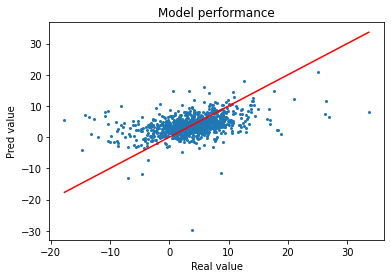

In [6]:
#Predicted Value Plot

fig, ax = plt.subplots()
plot_range = [results_df["y_real"].min(), results_df["y_real"].max()] 
ax.set_title("Model performance")
ax.set_ylabel("Pred value")
ax.set_xlabel("Real value")

ax.scatter(results_df["y_real"], results_df["y_pred"], s=4)
ax.plot(plot_range, plot_range, c="red")
plt.show()

In [7]:
#We have to make the predict for the year 2011, using the last indicators info
#And write the info on the data-base

country_list = df.index.unique('Country')
country_list

#Last indicators information
pivoted_df = pivoted_df.dropna(axis='columns',thresh=6000)
pivoted_df = pivoted_df.dropna()
pivoted_df.drop(columns=["GDP growth (annual %)"], inplace=True)
pivoted_df 

#Dataframe with all the countries
results_test = pd.DataFrame(country_list) 

#Array to save all the predicted values of the last year
Predicted_values = np.array([])
#We will have to add the prediction function
for country in country_list:    
    pred_indicators = pivoted_df.loc[country].iloc[[-1]] #Select last row of each contry.
    gbm_y_pred = gbm_model.predict(pred_indicators)
    Predicted_values = np.append(Predicted_values,gbm_y_pred)

results_test["GDP Growth Prediciton ( Year 2011 )"] = Predicted_values
results_test

,Country,GDP Growth Prediciton ( Year 2011 )
0,Afghanistan,9.076616
1,Albania,3.641897
2,Algeria,4.534934
3,Argentina,8.287750
4,Armenia,3.563341
...,...,...
157,Venezuela,0.390500
158,Vietnam,5.080809
159,Yemen,3.414100
160,Zambia,6.453874
